# Simulating Deuteron $H_2$ with XACC-VQE
To run this problem via docker, run the following from an empty directory

```bash
$ docker run --name xacc-notebook -it -p 8888:8888 -d -v $(pwd):/home/notebooks xacc/xacc-all-gate-jupyter-fc26
$ (to see jupyter notebook URL) docker logs xacc-notebook
```

## Import necessary libraries, create the Hamiltonian and Ansatz Circuits

In [2]:
import sys
sys.path.append('/usr/local/xacc/lib/python')
import numpy as np
import pyxacc as xacc
from pyxacc import InstructionParameter
import pyxaccvqe as vqe
from pyxaccvqe import PauliOperator
%matplotlib inline

xacc.Initialize(['--compiler','quil'])

# Specify the Accelerator to run on, 
# default to TNQVM MPS simulator
qpuName = 'tnqvm'
qpu = xacc.getAccelerator(qpuName)
errorMitigation = ['correct-readout-errors']
logicalToPhysicalQubitMapping = [0,1]
nQubits = max(logicalToPhysicalQubitMapping) + 1

# Construct the H2 Hamiltonian (see Eq 4 of paper)
H2 = PauliOperator(5.906709445) + \
    PauliOperator({0:'X',1:'X'}, -2.1433) + \
    PauliOperator({0:'Y',1:'Y'}, -2.1433) + \
    PauliOperator({0:'Z'}, .21829) + \
    PauliOperator({1:'Z'}, -6.125)

# Code up and compile the H2 ansatz in Quil
srcH2 = """__qpu__ ansatz(AcceleratorBuffer, double t0) {
X 0
RY(t0) 1
CNOT 1 0
}"""
ansatzH2 = xacc.Program(qpu, srcH2).getKernel('ansatz').getIRFunction()


## Parameter Sweep

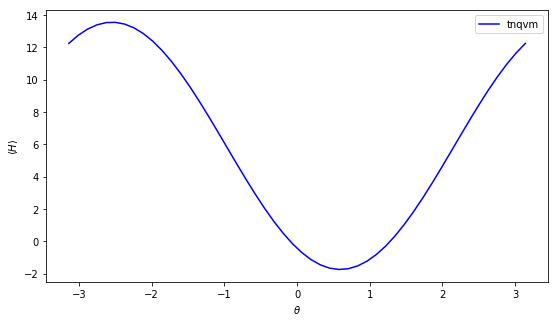

In [3]:
# Sweep over the given angle range for H2 and plot
angle_range = np.linspace(-np.pi,np.pi,50)
energiesH2 = [vqe.execute(H2, **{'task':'compute-energy', 
                                        'vqe-params':str(t), 
                                        'ansatz':ansatzH2, 'n-qubits':nQubits,
                                        'error-mitigation':errorMitigation, 
                                        'qubit-map':logicalToPhysicalQubitMapping}).energy 
            for t in angle_range]
import matplotlib.pyplot as plt
plt.figure(figsize=(9,5))
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\langle H\rangle$')
plt.plot(angle_range, energiesH2, '-', color='b', label=r'tnqvm')
plt.legend()
plt.show()


## VQE routine

In [4]:
# Execute H2 VQE routine
vqeResultH2 = vqe.execute(H2, **{'task':'vqe', 'ansatz':ansatzH2, 
                                 'error-mitigation':errorMitigation, 
                                 'qubit-map':logicalToPhysicalQubitMapping})
print('H2 (Optimal Angle, Energy) = (', vqeResultH2.angles, ',', vqeResultH2.energy, ')')

H2 (Optimal Angle, Energy) = ( [0.59457095] , -1.7491551404540182 )
